本节将介绍提高循环神经网络的性能和泛化能力的3种高级技巧。将在温度预测问题中介绍这三个概念，在这个问题中，数据包括温度、气压、湿度等，利用这些数据来预测24小时之后的温度
* **循环dropout**，这是一种特殊的内置方法，在循环层中使用dropout来降低过拟合
* **堆叠循环层**，这会提高网络的表示能力
* **双向循环层**，将相同信息以不同的方式呈现给循环网络，可以提高精度并缓解遗忘问题

## 6.3.1 温度预测问题
在本节中将使用一个天气时间序列数据集，在这个数据集中，每十分钟记录14个不同的量（温度、气压、湿度、风向等），使用2009-2016年的数据。这个数据非常适合用来学习处理数据型事件序列。  
[数据下载链接](https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip)

In [1]:
#1、观察耶拿天气数据集的数据
import os

filename = 'D:\\Download\\jena_climate_2009_2016.csv\\jena_climate_2009_2016.csv'

with open(filename) as f:
    data = f.read()
    f.close()
    
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)    #表头（15列，第一列是时间，其余列是对应的数据值）
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [2]:
#利用pandas显示数据
%matplotlib inline
import pandas as pd

df = pd.read_csv(filename)
df.tail()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
420446,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420447,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420448,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420449,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8
420450,01.01.2017 00:00:00,999.82,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


In [3]:
#2、解析数据
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    value = [ float(x) for x in line.split(',')[1:] ]
    float_data[i, :] = value

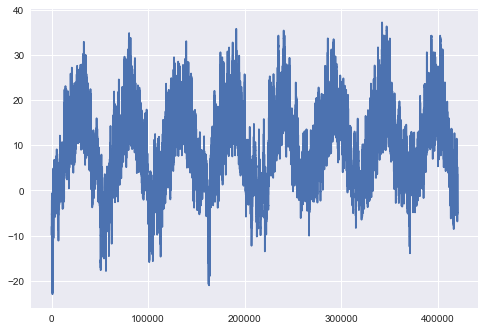

In [4]:
#3、绘制温度时间序列
import matplotlib.pyplot as plt

temp = float_data[:, 1]

plt.style.use('seaborn')
fig, ax = plt.subplots()
plt.plot(range(1, len(temp)+1), temp)
plt.show()

"""
在kaggle中的命令：
data_path = '../input/jena-climate-2009-2016/jena_climate_2009_2016.csv'

import pandas as pd
data = pd.read_csv(data_path)
data.head()

data["T (degC)"].plot()
data[: 1440]["T (degC)"].plot()
"""

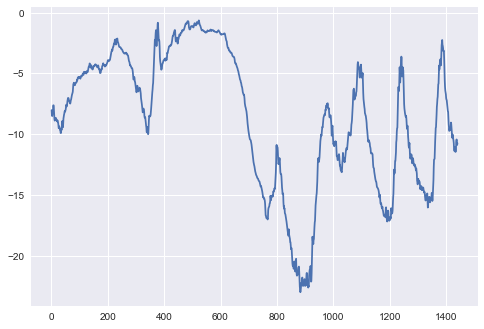

In [5]:
#4、绘制前10天的数据
plt.plot(range(1, 1441), temp[:1440])
plt.show()

## 6.3.2 准备数据
在这个问题中它的准确描述如下，每step个时间步采样一次数据，给定过去lookback个时间步之内的数据，能否预测delay个时间步之后的温度？  
用到的参数定义如下：  
* lookback = 720，给定过去5天内的观测数据 
* setps = 6，观测数据的采样频率是每个小时一个数据点（从第一个时间点开始每steps步之后进行一次采样）
* delay = 144，目标是未来24小时之后的数据

在开始之前需要完成两件事：
* 将数据预处理为神经网络可以处理的格式。现在的数据已经是数值型的，所以不需要进行向量化，但数据中的每个时间序列位于不同范围，需要对每个时间序列分别进行标准化，让他们在相似的范围内取到较小值
* **编写一个Python生成器，以当前浮点数数组作为输入，并且从最近的数据中生成批量，同时生成未来的目标温度**

将取值范围差异很大的数据输入到神经网络当中，网络可能会自动适应这种取值范围不同的数据，但学习肯定会变得更加困难  
对于这种数据，普遍采取的最佳实践是对每个特征做标准化处理  
**数据的标准化: (数据值x - 平均值μ) / (方差σ)**  
  
#### 在这里从训练集上得到需要的平均值mean和方差std   
#### 再用得到的方差在训练集和验证集上进行预处理

In [6]:
#数据标准化
mean = float_data[: 200000].mean(axis = 0)
std = float_data[: 200000].std(axis = 0)

float_data -= mean
float_data /= std

* data：浮点数数据组成的原始数据
* lookback：输入数据应该包含多少个时间步
* delay：目标应该在未来多少个时间步之后
* min_index和max_index：data数组中的索引，用于界定需要抽取那些时间步，有助于保存一部分数据用于验证、一部分的数据用于测试
* shuffle：是打乱样本还是按顺序抽取样本
* batch_size：每个批量的样本数
* step：数据采样的周期（单位：时间步），设置为6表示每个小时抽取一个数据点

In [7]:
#5、生成事件序列样本及其目标的生成器
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data)- delay - 1

    i = min_index + lookback

    while 1:
        if shuffle:
            rows = np.random.randint(min_index+lookback, max_index, size = batch_size)

        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i+batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))

        targets = np.zeros((len(rows), ))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]

        yield samples, targets    

In [8]:
#6、准备训练数据、验证数据和测试数据生成器
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 0, max_index = 200000,
                      shuffle = True, step = step, batch_size = batch_size)

val_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 200001, max_index = 300000,
                    step = step, batch_size = batch_size)

test_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 300000, max_index = None,
                    step = step, batch_size = batch_size)

# 为了查看整个验证数据集需要从val_gen中抽取的次数
val_steps = (300000 - 200001 - lookback) // batch_size

# 为了查看整个测试数据集需要从test_gen中抽取的次数
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### 6.3.3 一种基于常识的、非机器学习的基准方法
假设温度时间序列是连续的（明天的温度很可能接近今天的温度），并且具有每天的周期性变化。因此，一种基于常识的方法就是始终24小时之后的温度等于现在的温度，我们使用平均绝对误差来评估这种方法。  
np.mean(np.abs(preds - targets))

In [9]:
#7、计算符合常识的基准方法的MAE
def evaluate_naive_method():
    batch_mae = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_mae.append(mae)
    print(np.mean(batch_mae))
    
evaluate_naive_method()

0.2897359729905488


In [10]:
#8、将MAE转换成摄氏温度误差
celsius_mae = 0.29 * std[1]
print(celsius_mae)

2.5672247338393377


### 6.3.4 一种基本的机器学习方法
**使用RNN建立一个简单并且计算代价较低的模型也很有用，可以进一步保证增加问题的复杂度是合理的，并且会带来好处**  
下面建立一个密集连接模型，首先将数据展平，然后通过两个Dense层并运行，注意最后一层没有使用激活函数（回归问题）

In [11]:
#9、评估并训练一个密集连接模型
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.summary()
plot_model(model, show_shapes = True, to_file = 'Dense Neural Network.png')

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3360)              0         
                                                                 
 dense (Dense)               (None, 32)                107552    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


<ipython-input-11-94f5400e5b9d>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/20
500/500 [==============================] - 8s 16ms/step - loss: 1.0438 - val_loss: 0.4367
Epoch 2/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3486 - val_loss: 0.2996
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2825 - val_loss: 0.3659
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2624 - val_loss: 0.3065
Epoch 5/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2505 - val_loss: 0.3121
Epoch 6/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2410 - val_loss: 0.3159
Epoch 7/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2348 - val_loss: 0.3172
Epoch 8/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2296 - val_loss: 0.3261
Epoch 9/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2235 - val_loss: 0.3322
Epoch 10/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2196 - val_lo

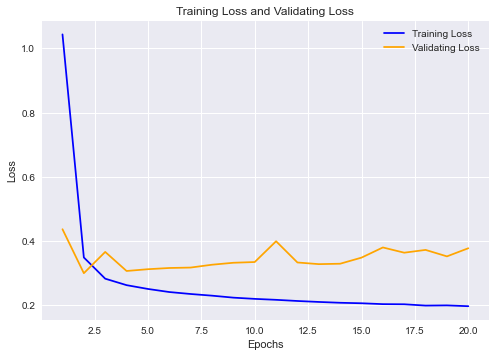

In [12]:
#10、绘制训练损失和验证损失
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'blue', label = "Training Loss")
plt.plot(epochs, val_loss, 'orange', label = "Validating Loss")
plt.title("Training Loss and Validating Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
print(min(val_loss))

### 6.3.5 第一个循环网络基准
在前面的方法中，首先将数据全部输入到神经网络当中，这就忽略了数据的时间特征。而对于温度预测问题而言，基于时间来进行预测会带来更好的效果。

In [13]:
#11、训练并评估一个基于GRU的模型
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

model.summary()
plot_model(model, show_shapes = True, to_file = 'GRU Neural Network.png')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                4608      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


<ipython-input-13-49ded777bfa6>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 39s 75ms/step - loss: 0.3033 - val_loss: 0.2714
Epoch 2/20
500/500 [==============================] - 39s 79ms/step - loss: 0.2829 - val_loss: 0.2804
Epoch 3/20
500/500 [==============================] - 38s 76ms/step - loss: 0.2771 - val_loss: 0.2610
Epoch 4/20
500/500 [==============================] - 37s 75ms/step - loss: 0.2712 - val_loss: 0.2592
Epoch 5/20
500/500 [==============================] - 38s 75ms/step - loss: 0.2708 - val_loss: 0.2604
Epoch 6/20
500/500 [==============================] - 38s 75ms/step - loss: 0.2671 - val_loss: 0.2609
Epoch 7/20
500/500 [==============================] - 37s 75ms/step - loss: 0.2625 - val_loss: 0.2629
Epoch 8/20
500/500 [==============================] - 37s 75ms/step - loss: 0.2570 - val_loss: 0.2638
Epoch 9/20
500/500 [==============================] - 37s 75ms/step - loss: 0.2531 - val_loss: 0.2670
Epoch 10/20
500/500 [==============================] - 37s 74ms/step - loss: 0.2480 - val_los

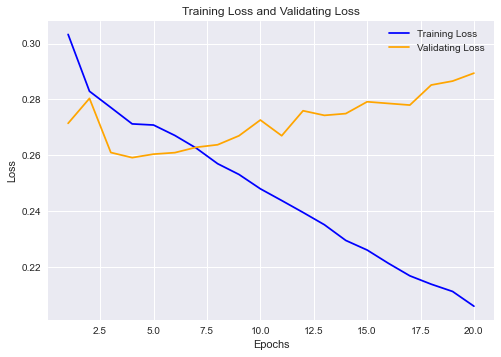

In [14]:
#绘制训练损失和验证损失
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'blue', label = "Training Loss")
plt.plot(epochs, val_loss, 'orange', label = "Validating Loss")
plt.title("Training Loss and Validating Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
print(val_loss)

**上图显示了模型结果，效果好多了！远优于基于常识的基准方法，这证明了机器学习的价值，也证明了循环神经网络与这种序列展平的密集连接网络相比在这种任务上的优势。**

上面的验证MAE大约在0.26左右（在第四次训练之后就开始出现严重的过拟合了），和之前的0.29相比有了一定的提升。

### 6.3.6 使用循环dropout来降低过拟合
在2015年，Yarin Gal在他的有关贝叶斯深度学习的博士学位论文中，发现了在循环网络中使用dropout的正确方法：也就是在每个时间步长上都应用相同的dropout掩码（dropout mask，相同模式的舍弃单元），应该避免在每个时间的增加而随机变化。
此外对GRU、LSTM等循环层得到的表示做正则化，应该将不随时间而变化的dropout掩码应用于层的内部激活（叫做循环dropout掩码）。对每个时间步使用相同的dropout掩码，可以让网络随着时间正确地传播其学习误差，而随时间变化的dropout掩码则会破话这个误差信号，且不利于学习过程。

In [15]:
#12、训练并评估一个使用dropout正则化的基于GRU的模型
model = Sequential()
model.add(layers.GRU(32, 
                     dropout = 0.2,
                     recurrent_dropout = 0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.summary()

model.compile(optimizer=RMSprop(), loss='mae')

plot_model(model, show_shapes = True, to_file = 'GRU Neural Network with dropout.png')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

<ipython-input-15-7a25d8164a11>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/20
500/500 [==============================] - 57s 111ms/step - loss: 0.3198 - val_loss: 0.2776
Epoch 2/20
500/500 [==============================] - 56s 113ms/step - loss: 0.3040 - val_loss: 0.2743
Epoch 3/20
500/500 [==============================] - 57s 115ms/step - loss: 0.2995 - val_loss: 0.2748
Epoch 4/20
500/500 [==============================] - 59s 119ms/step - loss: 0.2937 - val_loss: 0.2698
Epoch 5/20
500/500 [==============================] - 60s 120ms/step - loss: 0.2901 - val_loss: 0.2644
Epoch 6/20
500/500 [==============================] - 61s 122ms/step - loss: 0.2844 - val_loss: 0.2699
Epoch 7/20
500/500 [==============================] - 60s 120ms/step - loss: 0.2824 - val_loss: 0.2694
Epoch 8/20
500/500 [==============================] - 60s 120ms/step - loss: 0.2773 - val_loss: 0.2697
Epoch 9/20
500/500 [==============================] - 60s 121ms/step - loss: 0.2737 - val_loss: 0.2702
Epoch 10/20
500/500 [==============================] - 60s 121ms/step - l

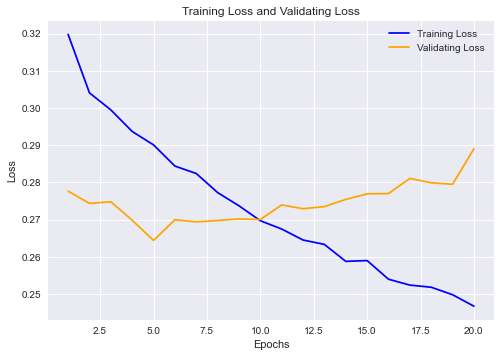

In [16]:
#绘制训练损失和验证损失
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'blue', label = "Training Loss")
plt.plot(epochs, val_loss, 'orange', label = "Validating Loss")
plt.title("Training Loss and Validating Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

经过dropout之后，模型过拟合的速度开始放缓，dropout的比率是一个超参数，可以尝试使用不同的dropout比率的模型来训练

### 6.3.7 循环层堆叠
**现在过拟合已经不再是问题，不过我们好像碰到了性能的瓶颈，下面应该考虑增加网络的容量**。如果你还记得前面介绍过得“通用机器学习流程”：在过拟合变成主要障碍之前，增加网络容量都是一个好主意（前提是你已经采取了基本的方法来限制过拟合了，比方说使用dropout）。只要你没有出现严重的过拟合，那么通常来说就是因为网络的容量不足。

增加层内的单元数或者增加更多层都是增加网络容量的典型方法。堆叠循环层是构建更加强大循环网络的经典做法：例如目前谷歌翻译算法使用的就是7个大型LSTM层堆叠起来的网络，相当巨大。

要在Keras中堆叠循环层，所有中间层都需要返回完整的序列输出（一个3D张量）而不仅是最后一个时间步长的输出。这可以通过设置`return_sequences=True`参数来实现：

In [17]:
#13、训练并评估一个使用dropout正则化的堆叠GRU模型
model = Sequential()
model.add(layers.GRU(32, dropout=0.1,
                     recurrent_dropout=0.5, return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, dropout=0.1,
                     recurrent_dropout=0.5, activation='relu'))
model.add(layers.Dense(1))

from tensorflow.keras.utils import plot_model

model.summary()
plot_model(model, show_shapes = True, to_file = 'stacked GRU Neural Network with dropout.png')

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, None, 32)          4608      
                                                                 
 gru_3 (GRU)                 (None, 64)                18816     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 23,489
Trainable params: 23,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


<ipython-input-17-45591f6f5cbe>:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 157s 308ms/step - loss: 0.3210 - val_loss: 0.2814
Epoch 2/20
500/500 [==============================] - 160s 320ms/step - loss: 0.3042 - val_loss: 0.2717
Epoch 3/20
500/500 [==============================] - 163s 326ms/step - loss: 0.2954 - val_loss: 0.2773
Epoch 4/20
500/500 [==============================] - 163s 325ms/step - loss: 0.2931 - val_loss: 0.2713
Epoch 5/20
500/500 [==============================] - 156s 311ms/step - loss: 0.2855 - val_loss: 0.2733
Epoch 6/20
500/500 [==============================] - 160s 320ms/step - loss: 0.2795 - val_loss: 0.2720
Epoch 7/20
500/500 [==============================] - 159s 318ms/step - loss: 0.2740 - val_loss: 0.2771
Epoch 8/20
500/500 [==============================] - 160s 321ms/step - loss: 0.2663 - val_loss: 0.2780
Epoch 9/20
500/500 [==============================] - 173s 347ms/step - loss: 0.2627 - val_loss: 0.3042
Epoch 10/20
500/500 [==============================] - 161s 321ms/step - lo

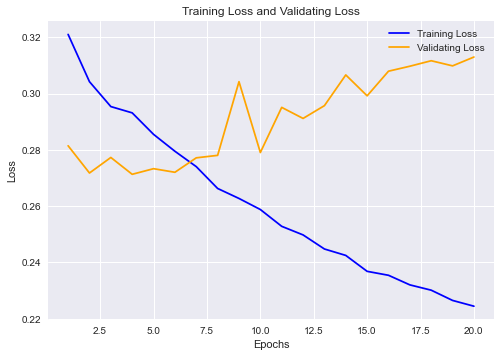

In [18]:
#绘制训练损失和验证损失
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'blue', label = "Training Loss")
plt.plot(epochs, val_loss, 'orange', label = "Validating Loss")
plt.title("Training Loss and Validating Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

将上面的GRU模型换成LSTM模型，虽然参数会变多，训练的时间也会相应的变长，但是效果和可解释性更强

In [ ]:
#13、训练并评估一个使用dropout正则化的堆叠GRU模型
model = Sequential()
model.add(layers.LSTM(32, dropout=0.1,
                     recurrent_dropout=0.5, return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.LSTM(64, dropout=0.1,
                     recurrent_dropout=0.5, activation='relu'))
model.add(layers.Dense(1))

from tensorflow.keras.utils import plot_model

model.summary()
plot_model(model, show_shapes = True, to_file = 'stacked LSTM Neural Network with dropout.png')

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

#绘制训练损失和验证损失
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'blue', label = "Training Loss")
plt.plot(epochs, val_loss, 'orange', label = "Validating Loss")
plt.title("Training Loss and Validating Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 6.3.8 使用双向RNN
之前的RNN都是按照时间正序处理的，那么按时间逆序处理效果会不会更好呢  
编写一个数据生成器变体，将输入序列沿着时间维度反转（最后一行为yield samples[:, ::-1, 1 ], targets）

In [19]:
#生成事件序列样本及其目标的生成器（按时间逆序）
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data)- delay - 1

    i = min_index + lookback

    while 1:
        if shuffle:
            rows = np.random.randint(min_index+lookback, max_index, size = batch_size)

        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i+batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))

        targets = np.zeros((len(rows), ))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]

        yield samples[:, ::-1, l], targets    #和之前的generator相比，只有最后一行不同
        
#准备训练数据、验证数据和测试数据生成器
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen_backup = generator(float_data, lookback = lookback, delay = delay, min_index = 0, max_index = 200000,
                      shuffle = True, step = step, batch_size = batch_size)

val_gen__backup = generator(float_data, lookback = lookback, delay = delay, min_index = 200001, max_index = 300000,
                    step = step, batch_size = batch_size)

#train_gen、val_gen、test_gen均是按照时间正序的生成器，train_gen_backup、val_gen_backup是按照时间逆序生成的生成器

In [20]:
#训练并评估一个基于GRU的模型（利用之后的温度来预测当前的温度）
model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

model.summary()
plot_model(model, show_shapes = True, to_file = 'GRU Neural Network with reverse time sequences.png')

history = model.fit_generator(train_gen_backup,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen__backup,
                              validation_steps=val_steps)

#绘制训练损失和验证损失
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'blue', label = "Training Loss")
plt.plot(epochs, val_loss, 'orange', label = "Validating Loss")
plt.title("Training Loss and Validating Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 32)                4608      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


<ipython-input-20-9b3687a097a9>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/20
500/500 [==============================] - 41s 79ms/step - loss: 0.3205 - val_loss: 0.2727
Epoch 2/20
500/500 [==============================] - 41s 81ms/step - loss: 0.2861 - val_loss: 0.2736
Epoch 3/20
500/500 [==============================] - 40s 81ms/step - loss: 0.2805 - val_loss: 0.2670
Epoch 4/20
500/500 [==============================] - 40s 81ms/step - loss: 0.2747 - val_loss: 0.2631
Epoch 5/20
500/500 [==============================] - 40s 81ms/step - loss: 0.2684 - val_loss: 0.2770
Epoch 6/20
500/500 [==============================] - 41s 81ms/step - loss: 0.2649 - val_loss: 0.2662
Epoch 7/20
500/500 [==============================] - 40s 80ms/step - loss: 0.2576 - val_loss: 0.2712
Epoch 8/20
500/500 [==============================] - 40s 80ms/step - loss: 0.2528 - val_loss: 0.2782
Epoch 9/20
500/500 [==============================] - 39s 79ms/step - loss: 0.2494 - val_loss: 0.2762
Epoch 10/20
500/500 [==============================] - 40s 80ms/step - loss: 0.243

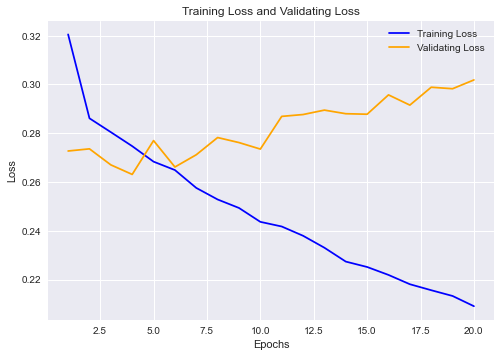

In [21]:
#训练并评估一个基于LSTM的模型（数据按照时间逆序，利用之后的温度来预测当前的温度）
model = Sequential()
model.add(LSTM(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

model.summary()
plot_model(model, show_shapes = True, to_file = 'LSTM Neural Network with reverse time sequences.png')

history = model.fit_generator(train_gen_backup,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_backup,
                              validation_steps=val_steps)

#绘制训练损失和验证损失
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'blue', label = "Training Loss")
plt.plot(epochs, val_loss, 'orange', label = "Validating Loss")
plt.title("Training Loss and Validating Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

尝试在IMDB示例中的LSTM应用相同的技巧（对数据的处理从后往前）

25000 25000
(25000, 500) (25000, 500)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
118/118 [==============================] - 23s 181ms/step - loss: 0.5731 - accuracy: 0.7045 - val_loss: 1.1581 - val_accuracy: 0.5228
Epoch 2/10
118/118 [==============================] - 21s 180ms/step - loss: 0.3712 - accuracy: 0.8519 - val_loss: 0.5039 - val_a

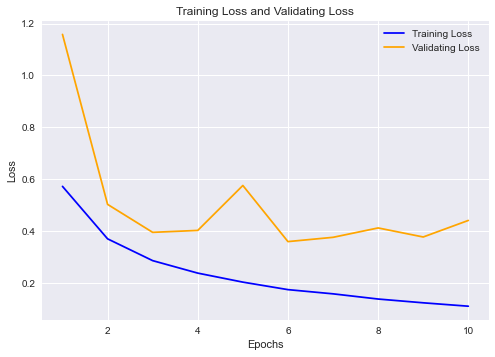

In [22]:
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN, LSTM
from keras.preprocessing.sequence import pad_sequences

max_word = 10000    #最常见的10000词
embedding_dim = 32  #shape(x) = 32
state_dim = 32      #shape(h) = 32
max_len = 500       #截取前500个词

#1、从Keras中加载数据集
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=max_word)

#2、将数据进行填充以便输入到Embedding层中
print(len(train_data), len(test_data))
train_data = [x[::-1] for x in train_data]
test_data = [x[::-1] for x in test_data]

train_data = pad_sequences(train_data, maxlen=max_len)
test_data = pad_sequences(test_data, maxlen=max_len)

#show train_data's and test_data's shape
print(train_data.shape, test_data.shape)

#3、构建RNN
network = Sequential()
network.add(Embedding(max_word, embedding_dim, input_length = max_len))
network.add(LSTM(32))
network.add(Dense(1, activation='sigmoid'))
network.summary()


#4、划分训练集和验证集
x_train = train_data[:15000]
y_train = train_labels[:15000]

x_val = train_data[15000:]
y_val = train_labels[15000:]

#5、编译网络
network.compile('rmsprop', 'binary_crossentropy', 'accuracy')
plot_model(network, show_shapes = True, to_file = 'LSTM Neural Network.png')

#6、拟合模型
history = network.fit(x_train, y_train, epochs = 10, batch_size=128, validation_data=(x_val, y_val))

#绘制训练损失和验证损失
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'blue', label = "Training Loss")
plt.plot(epochs, val_loss, 'orange', label = "Validating Loss")
plt.title("Training Loss and Validating Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

可以看到反向GRU的性能比常识性基线还要低，**表明在这个任务中，正向时间顺序处理对于成功是比较关键的因素**。这很正常：因为GRU层能够更好的记住不久的过去而不是更远的过去，而在这个任务当中显然更近的天气数据比更久远的数据对预测更加有帮助（这正好说明了我们提出的那个常识性基线是很强大的基线）。所以正向时间的层次能够比反向时间的层次表现更出色。但是很重要的一点是在很多其他问题当中，上面的推理是不正确的，包括自然语言处理：通过直觉可知，理解一个句子意思，单词的重要性通常完全依赖于它在句子中的位置。

**双向RNN能利用这个方法来改善正向时间顺序RNN的性能：它会从两个方向处理输入序列，从而获取更加丰富的表现形式，并且可以捕获到那些正向模型遗漏的模式。**

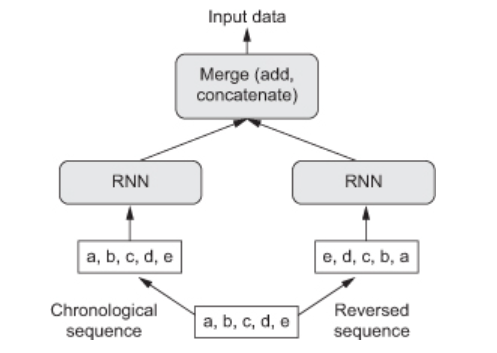

图6-24 双向RNN的工作模式

25000 25000
(25000, 500) (25000, 500)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 336,705
Trainable params: 336,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
118/118 [==============================] - 44s 354ms/step - loss: 0.5418 - accuracy: 0.7428 - val_loss: 0.4545 - val_accuracy: 0.8311
Epoch 2/10
118/118 [==============================] - 41s 352ms

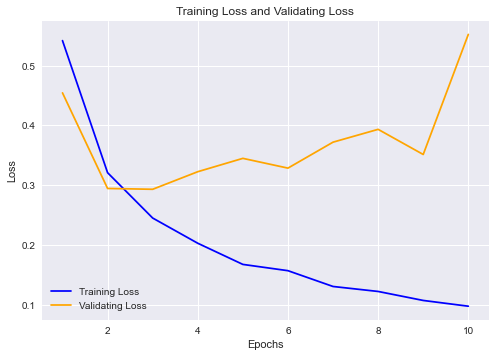

In [23]:
#评估并训练一个双向LSTM
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=max_word)

#2、将数据进行填充以便输入到Embedding层中
print(len(train_data), len(test_data))

train_data = pad_sequences(train_data, maxlen=max_len)
test_data = pad_sequences(test_data, maxlen=max_len)

#show train_data's and test_data's shape
print(train_data.shape, test_data.shape)

#3、构建双向LSTM
model = Sequential()
model.add(layers.Embedding(10000, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation = 'sigmoid'))

#4、划分训练集和验证集
x_train = train_data[:15000]
y_train = train_labels[:15000]

x_val = train_data[15000:]
y_val = train_labels[15000:]

#编译网络

model.compile('rmsprop', 'binary_crossentropy', 'accuracy')
model.summary()
plot_model(model, show_shapes = True, to_file = 'Bidrectional LSTM.png')

history = model.fit(x_train, y_train, epochs = 10, batch_size=128, validation_data=(x_val, y_val))

#绘制训练损失和验证损失
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'blue', label = "Training Loss")
plt.plot(epochs, val_loss, 'orange', label = "Validating Loss")
plt.title("Training Loss and Validating Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

接下来尝试将相同的方法应用于温度预测任务

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 64)               9216      
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,281
Trainable params: 9,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


<ipython-input-24-b99908070db4>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 60s 115ms/step - loss: 0.2918 - val_loss: 0.2705
Epoch 2/20
500/500 [==============================] - 57s 114ms/step - loss: 0.2752 - val_loss: 0.2634
Epoch 3/20
500/500 [==============================] - 59s 118ms/step - loss: 0.2680 - val_loss: 0.2629
Epoch 4/20
500/500 [==============================] - 61s 123ms/step - loss: 0.2593 - val_loss: 0.2619
Epoch 5/20
500/500 [==============================] - 62s 123ms/step - loss: 0.2573 - val_loss: 0.2680
Epoch 6/20
500/500 [==============================] - 63s 126ms/step - loss: 0.2492 - val_loss: 0.2671
Epoch 7/20
500/500 [==============================] - 62s 124ms/step - loss: 0.2437 - val_loss: 0.2662
Epoch 8/20
500/500 [==============================] - 62s 124ms/step - loss: 0.2365 - val_loss: 0.2721
Epoch 9/20
500/500 [==============================] - 62s 124ms/step - loss: 0.2329 - val_loss: 0.2817
Epoch 10/20
500/500 [==============================] - 62s 124ms/step - loss: 0.2258

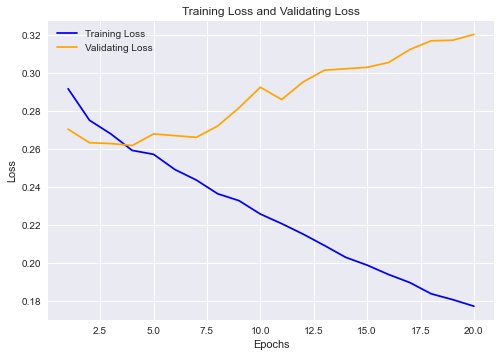

In [24]:
#训练一个双向GRU
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32),
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

from tensorflow.keras.utils import plot_model

model.summary()
plot_model(model, show_shapes = True, to_file = 'Bidirectional GRU Neural Network.png')

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

#绘制训练损失和验证损失
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'blue', label = "Training Loss")
plt.plot(epochs, val_loss, 'orange', label = "Validating Loss")
plt.title("Training Loss and Validating Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 64)               12032     
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12,097
Trainable params: 12,097
Non-trainable params: 0
_________________________________________________________________


<ipython-input-25-0dae0678d6ff>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/20
500/500 [==============================] - 79s 154ms/step - loss: 0.2886 - val_loss: 0.2747
Epoch 2/20
500/500 [==============================] - 74s 148ms/step - loss: 0.2638 - val_loss: 0.2798
Epoch 3/20
500/500 [==============================] - 73s 146ms/step - loss: 0.2498 - val_loss: 0.2923
Epoch 4/20
500/500 [==============================] - 73s 147ms/step - loss: 0.2352 - val_loss: 0.2931
Epoch 5/20
500/500 [==============================] - 73s 147ms/step - loss: 0.2237 - val_loss: 0.2975
Epoch 6/20
500/500 [==============================] - 73s 147ms/step - loss: 0.2123 - val_loss: 0.3078
Epoch 7/20
500/500 [==============================] - 73s 147ms/step - loss: 0.2046 - val_loss: 0.3129
Epoch 8/20
500/500 [==============================] - 73s 146ms/step - loss: 0.1984 - val_loss: 0.3168
Epoch 9/20
500/500 [==============================] - 73s 146ms/step - loss: 0.1903 - val_loss: 0.3226
Epoch 10/20
500/500 [==============================] - 73s 146ms/step - l

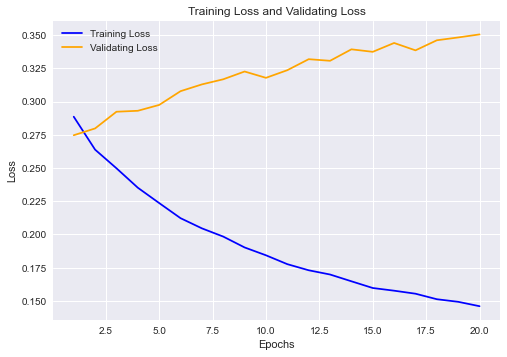

In [25]:
#使用双向LSTM来处理
model = Sequential()
model.add(layers.Bidirectional(layers.LSTM(32),
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

from tensorflow.keras.utils import plot_model

model.summary()
plot_model(model, show_shapes = True, to_file = 'Bidirectional LSTM Neural Network.png')

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

#绘制训练损失和验证损失
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'blue', label = "Training Loss")
plt.plot(epochs, val_loss, 'orange', label = "Validating Loss")
plt.title("Training Loss and Validating Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 6.3.9 更多尝试
为了提高温度预测问题的性能，你还可以尝试下面这些方法：
* 在堆叠循环层中调节每层的单元个数，当前取值在很大程度上是可以任意取值的，因此可能不是最优的（例如单元的个数32， 64， 128通过训练观察增加网络中每层单元个数是否会让模型更优）
* 调价RMSprop优化器的学习率
* 尝试使用LSTM代替GRU（虽然LSTM中的参数比GRU中的参数多1/3，但它的效果和可解释性更好）
* 在循环层上尝试使用更大的密接连接分类器，即更大的Dense层或Dense层的堆叠
* 不要忘记在测试集上运行性能最佳的模型（即验证MAE最小的模型），否则你开发的网络架构会对验证集过拟合

如前所述：深度学习更像一门艺术而非一门科学，虽然我们能够在特定问题上给出相关的指导，但最终每个问题都是独一无二的，  
你会需要凭经验尝试和衡量各种不同的策略。目前还没有任何理论能够提前精确的指引你如何才能最优化的解决一个问题。你必须不断试验和迭代。

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 64)                15360     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 15,425
Trainable params: 15,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


<ipython-input-26-e8340c9d8e44>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 121s 241ms/step - loss: 0.3031 - val_loss: 0.2677
Epoch 2/20
500/500 [==============================] - 118s 236ms/step - loss: 0.2829 - val_loss: 0.2642
Epoch 3/20
500/500 [==============================] - 118s 236ms/step - loss: 0.2708 - val_loss: 0.2592
Epoch 4/20
500/500 [==============================] - 119s 239ms/step - loss: 0.2619 - val_loss: 0.2652
Epoch 5/20
500/500 [==============================] - 117s 235ms/step - loss: 0.2512 - val_loss: 0.2679
Epoch 6/20
500/500 [==============================] - 117s 234ms/step - loss: 0.2429 - val_loss: 0.2767
Epoch 7/20
500/500 [==============================] - 117s 234ms/step - loss: 0.2335 - val_loss: 0.2789
Epoch 8/20
500/500 [==============================] - 118s 236ms/step - loss: 0.2223 - val_loss: 0.2871
Epoch 9/20
500/500 [==============================] - 118s 236ms/step - loss: 0.2114 - val_loss: 0.2884
Epoch 10/20
500/500 [==============================] - 118s 235ms/step - lo

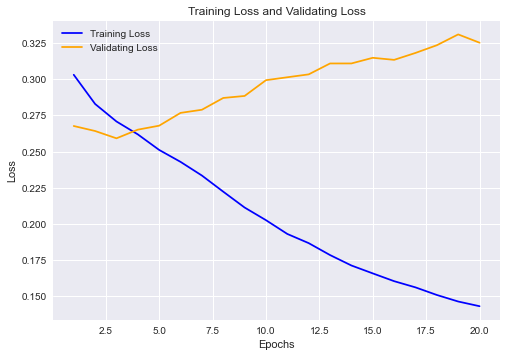

In [26]:
#训练并评估一个基于GRU的模型（增加了模型中每层单元的个数）
model = Sequential()
model.add(layers.GRU(64, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

model.summary()
plot_model(model, show_shapes = True, to_file = 'GRU Neural Network.png')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'blue', label = "Training Loss")
plt.plot(epochs, val_loss, 'orange', label = "Validating Loss")
plt.title("Training Loss and Validating Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [27]:
#查看在训练过程中在验证集上验证的最小损失是多少
print(min(val_loss))

0.2591840624809265


In [28]:
#13、训练并评估一个使用dropout正则化的堆叠GRU模型
model = Sequential()
model.add(LSTM(32, 
               dropout=0.1,
               recurrent_dropout=0.5, 
               return_sequences=True,
               input_shape=(None, float_data.shape[-1])))
model.add(LSTM(64, 
               dropout=0.1,
               recurrent_dropout=0.5, activation='relu'))
model.add(layers.Dense(1))

from tensorflow.keras.utils import plot_model

model.summary()
plot_model(model, show_shapes = True, to_file = 'stacked GRU Neural Network with dropout.png')

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, None, 32)          6016      
                                                                 
 lstm_4 (LSTM)               (None, 64)                24832     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 30,913
Trainable params: 30,913
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


<ipython-input-28-65687c060c4a>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 218s 430ms/step - loss: 0.4258 - val_loss: 0.3706
Epoch 2/20
500/500 [==============================] - 220s 440ms/step - loss: 0.3689 - val_loss: 0.2859
Epoch 3/20
500/500 [==============================] - 224s 448ms/step - loss: 0.3027 - val_loss: 0.2772
Epoch 4/20
500/500 [==============================] - 227s 454ms/step - loss: nan - val_loss: nan
Epoch 5/20
500/500 [==============================] - 225s 450ms/step - loss: nan - val_loss: nan
Epoch 6/20
500/500 [==============================] - 226s 452ms/step - loss: nan - val_loss: nan
Epoch 7/20
500/500 [==============================] - 226s 452ms/step - loss: nan - val_loss: nan
Epoch 8/20
500/500 [==============================] - 226s 453ms/step - loss: nan - val_loss: nan
Epoch 9/20
500/500 [==============================] - 226s 452ms/step - loss: nan - val_loss: nan
Epoch 10/20
500/500 [==============================] - 226s 451ms/step - loss: nan - val_loss: nan
Epoch 11/20


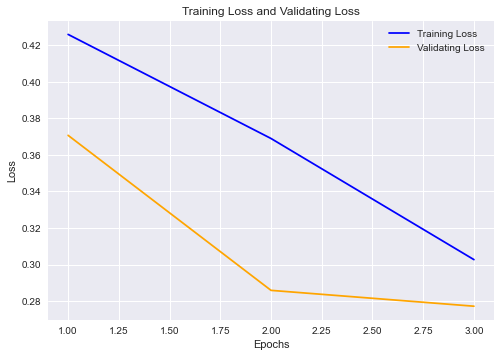

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'blue', label = "Training Loss")
plt.plot(epochs, val_loss, 'orange', label = "Validating Loss")
plt.title("Training Loss and Validating Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [34]:
#查看在训练过程中在验证集上验证的最小损失是多少
print(min(val_loss))

0.2772330641746521


### 6.3.10 小结
下面是本小节你应该掌握的知识：

- 就像第四章时介绍过的，当遇到一个新问题时，最好能够首先建立常识性的基准，作为后续方法的参照。如果你没有基准可以对比，你将难以判断是否真的有效。
- 在尝试计算较高的模型之前首先试验简单的模型，这样能判断付出计算代价是有意义的。有时可能简单的模型就是最佳选择。
- 如果时间顺序对数据很重要，循环网络是非常合适的选择，它们能够很容易的击败那些将数据铺平的普通模型。
- 要在循环网络中应用dropout， 需要一个时间段不变的dropout掩码和一个循环dropout掩码。它们是内置在Keras的循环层中的，因此你仅需要在循环层中设置dropout和recurrent_dropout参数即可。
- 堆叠的RNN比单层RNN有着更大的表现形式空间，从而有着更多的表现能力。但是它的计算代价更高，因此并不是在所有情况下都需要。虽然堆叠RNN在复杂问题上（例如机器翻译）获得了明显的进步，但是在小型简单问题上这并总是相关的。
- 双向RNN，可以从正向与反向同时观察数据，对于自然语言处理问题是非常有帮助的。然而，它们在那些近期过往数据比远期过往数据要重要很多的任务中并不会产生良好的效果。


这里要说明一下，有两个重要的概念这一节当中没有详细介绍：循环“注意力”和序列遮罩。它们都与自然语言处理相关，对于我们的天气预测问题不是特别合适。这里将它们留给读者作为本书外的额外学习内容。


最后用一个特别的提醒来结束本节，一些读者可能会希望将本节介绍的内容用于预测股价趋势（或者汇率趋势等）。作为一个警告：交易市场有着非常不同的统计学特征，和比如天气这类的自然现象差异非常大。试图仅在获取到公开可用数据的情况下使用机器学习的方法来预测市场是非常困难的，你很可能会浪费了时间和资源却一无所获。永远记住在交易市场领域中，过去的表现并不是未来回归的一个好指标，期待使用过往数据镜像成未来数据不是一个可行的做法。而机器学习只能应用在那些过去就是未来的良好预测指标的数据集之上。